# Bootstrapping confidence intervals

A confidence interval is used to estimate the range within which a population parameter is likely to lie, with a given level of confidence. What do we mean by _population parameter_? It's a value for which describes our population (data), such as the mean.

You'll commonly hear about _95% confidence intervals_. These are intervals (ranges) which will contain the population parameter 95% of the time.

The `seaborn` library has a `regplot` function which creates a scatterplot, fits a line using linear regression, and also displays the 95% confidence interval. We use the `"tips"` dataset provided by `seaborn` as example data. (I've also added some arguments to set the colors in the plot.)


<AxesSubplot:xlabel='total_bill', ylabel='tip'>

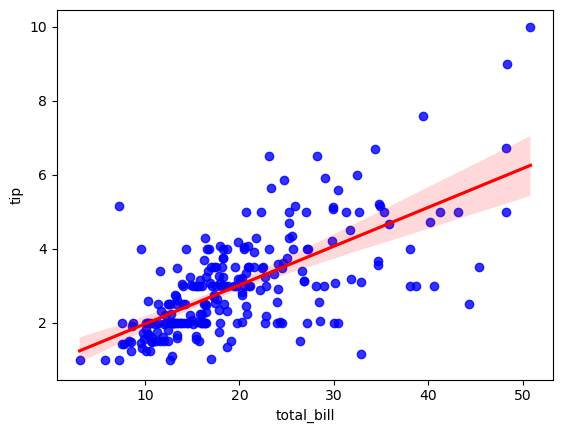

In [1]:
import seaborn as sns

tips = sns.load_dataset("tips")
X = tips["total_bill"]
y = tips["tip"]

sns.regplot(x=X, y=y, ci=95, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

Above, we can see that the confidence intervals are narrow when the data is more clustered (low variance) and thus our estimate of the population parameter is more precise. When the data is more spread out (high variance) there's greater uncertainty in the estimation of the population parameter, thus the confidence intervals increase.

How can we create these confidence intervals ourselves? The method we'll look at in this notebook is creating them via _bootstrapping_. Bootstrapping is used to describe a wide variety of techniques, all of which use re-sampling using replacement. For example, if we wanted to estimate the mean of some data using bootstrapping, we would:

-   sample (with replacement) from our original data, taking as many samples as are in the original data
-   calculate the mean from our bootstrapped sample
-   repeat this multiple times, keeping track of each mean calculated
-   sort the mean values
-   if we wanted the 95% confidence interval, we'd take the 2.5th and 97.5th percentiles as the minimum and maximum (respectively)

Why not just use the actual mean from the data? Because bootstrapping is used to calculate the uncertainty around a value, rather than the value itself.

Below, we start creating the `regplot`. We fit a scikit learn `LinearRegression` model (`clf`) to the data and then plot both the data and the model with `matplotlib`.


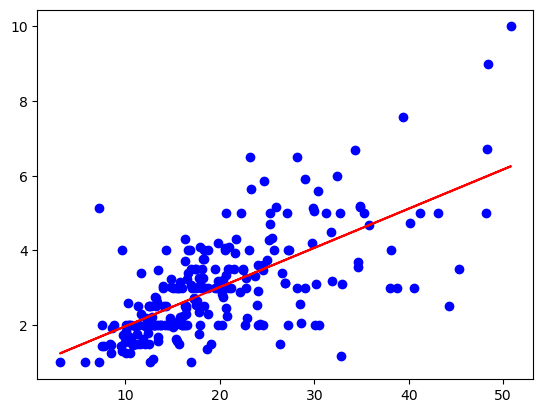

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

X = np.array(tips["total_bill"]).reshape(-1, 1)
y = np.array(tips["tip"]).reshape(-1, 1)

clf = LinearRegression()
clf.fit(X, y)
y_pred = clf.predict(X)

fig, ax = plt.subplots()
ax.scatter(X, y, color="blue")
ax.plot(X, y_pred, color="red")

For the actual bootstrapping, we're not estimating the mean, but instead: for each bootstrapped estimate (of which there will be `n_boots`), we will perform the re-sampling with replacement (to get `sampled_X` and `sampled_Y`), then fit a `LinearRegression` model (`_clf`) to the samples, and then use that model to predict values across `n_bins` points between the minimum and maximum of our data (`_preds` obtained across `grid`).

This gives us `n_boots` bootstrapped estimates along the `n_bins` points, and we get the bootstrapped 95% confidence intervals by calculating the 2.5th and 97.5th percentiles across the `n_bins` points.


In [3]:
def get_bootstrap_results(X, y, n_bins=100, n_boots=1_000):
    """
    Generate bootstrap estimates for a linear regression model.
    """
    results = np.zeros(shape=(n_boots, n_bins))
    grid = np.linspace(np.min(X), np.max(X), n_bins).reshape(-1, 1)
    for i in range(n_boots):
        sample_indices = np.random.choice(len(X), len(X))
        sampled_X = X[sample_indices]
        sampled_y = y[sample_indices]
        _clf = LinearRegression()
        _clf.fit(sampled_X, sampled_y)
        _preds = _clf.predict(grid).reshape(-1)
        results[i] = _preds
    grid = grid.reshape(-1)
    return grid, results


def get_ci_values(bootstrap_results, ci=95):
    """
    Calculate confidence intervals from bootstrap results.
    """
    lower, upper = 50 - (ci / 2), 50 + (ci / 2)
    return np.nanpercentile(bootstrap_results, (lower, upper), axis=0)


grid, bootstrap_results = get_bootstrap_results(X, y)
ci_values = get_ci_values(bootstrap_results, 95)

Our `ci_values` gives us the range of the confidence interval for each value in `grid`.


In [4]:
grid[0], ci_values[:, 0]

(3.07, array([0.9122646, 1.5724489]))

We can then use `fill_between` to plot the confidence intervals.


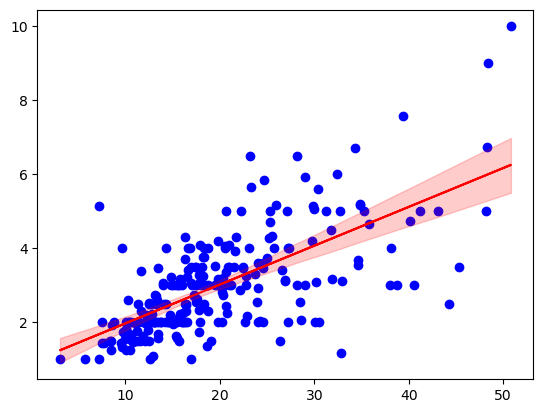

In [5]:
fig, ax = plt.subplots()
ax.scatter(X, y, color="blue")
ax.plot(X, y_pred, color="red")
ci_min, ci_max = ci_values[0, :], ci_values[1, :]
ax.fill_between(grid, ci_min, ci_max, color="red", alpha=0.2)